# Churn rate prediction of Telecom sector

In [33]:
%matplotlib inline
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from scipy.stats import chisquare


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from collections import Counter


import json
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


## Read data from sql

In [34]:
%run data_cleaning.ipynb

(4617, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4617 entries, 0 to 4616
Data columns (total 21 columns):
State                   4617 non-null object
Account Length          4617 non-null object
Area Code               4617 non-null object
Phone                   4617 non-null object
International Plan      4617 non-null object
VMail Plan              4617 non-null object
VMail Message           4617 non-null object
Day Mins                4617 non-null object
Day Calls               4617 non-null object
Day Charge              4617 non-null object
Eve Mins                4617 non-null object
Eve Calls               4617 non-null object
Eve Charge              4617 non-null object
Night Mins              4617 non-null object
Night Calls             4617 non-null object
Nights Charge           4617 non-null object
International Mins      4617 non-null object
International Calls     4617 non-null object
International Charge    4617 non-null object
CustServ Calls          461

Dataframe named data_encoded is available now

In [35]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4617 entries, 0 to 4616
Data columns (total 21 columns):
State                   4617 non-null int32
Account Length          4617 non-null int64
Area Code               4617 non-null int64
Phone                   4617 non-null int64
International Plan      4617 non-null int64
VMail Plan              4617 non-null int64
VMail Message           4617 non-null int64
Day Mins                4617 non-null float64
Day Calls               4617 non-null int64
Day Charge              4617 non-null float64
Eve Mins                4617 non-null float64
Eve Calls               4617 non-null int64
Eve Charge              4617 non-null float64
Night Mins              4617 non-null float64
Night Calls             4617 non-null int64
Nights Charge           4617 non-null float64
International Mins      4617 non-null float64
International Calls     4617 non-null int64
International Charge    4617 non-null float64
CustServ Calls          4617 non-null int

## Feature importances using random forest

In [36]:


model = RandomForestClassifier()


X = data_encoded.iloc[:,:-1]
y = data_encoded.Churn

test_size = .25

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print(accuracy_score(y_test, y_predict))

best_features = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1], reverse=True)

with open('feature_importances.txt', 'w') as f:
    best_features_1 = [(a, b.round(2)) for a, b in best_features]
    f.write(str(best_features_1))
best_features_1     

0.9497835497835497


[('Day Mins', 0.15),
 ('Day Charge', 0.11),
 ('CustServ Calls', 0.1),
 ('International Plan', 0.09),
 ('Eve Mins', 0.07),
 ('Eve Charge', 0.05),
 ('International Calls', 0.05),
 ('Night Mins', 0.04),
 ('International Mins', 0.04),
 ('Nights Charge', 0.04),
 ('Phone', 0.03),
 ('Day Calls', 0.03),
 ('International Charge', 0.03),
 ('State', 0.03),
 ('Eve Calls', 0.03),
 ('Account Length', 0.03),
 ('VMail Plan', 0.02),
 ('VMail Message', 0.02),
 ('Night Calls', 0.02),
 ('Area Code', 0.01)]

## Confusion matrix

We want the actual churn customers predicted as non churn to be zero
because we want to take care of those customers

So we want a zero in Actual - 1 Predicted - 0 column
Right now it is above 50 which is not ideal 

In [37]:
pd.crosstab(y_test, y_predict)

col_0,0,1
Churn,,
0,990,6
1,52,107


## We want recall to be 1

Right now recall is less than .7 in this model
We need to improve the model

In [38]:

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       996
           1       0.95      0.67      0.79       159

    accuracy                           0.95      1155
   macro avg       0.95      0.83      0.88      1155
weighted avg       0.95      0.95      0.95      1155



In [39]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4617 entries, 0 to 4616
Data columns (total 21 columns):
State                   4617 non-null int32
Account Length          4617 non-null int64
Area Code               4617 non-null int64
Phone                   4617 non-null int64
International Plan      4617 non-null int64
VMail Plan              4617 non-null int64
VMail Message           4617 non-null int64
Day Mins                4617 non-null float64
Day Calls               4617 non-null int64
Day Charge              4617 non-null float64
Eve Mins                4617 non-null float64
Eve Calls               4617 non-null int64
Eve Charge              4617 non-null float64
Night Mins              4617 non-null float64
Night Calls             4617 non-null int64
Nights Charge           4617 non-null float64
International Mins      4617 non-null float64
International Calls     4617 non-null int64
International Charge    4617 non-null float64
CustServ Calls          4617 non-null int

## Exploratory data analysis using box plots


Looks like account length is not affecting much

When VMail message, Day mins, Day calls, Eve mins, Eve charge, CustServCalls are high churn rate is more



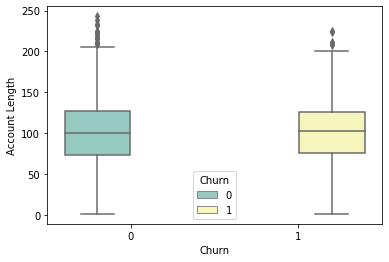

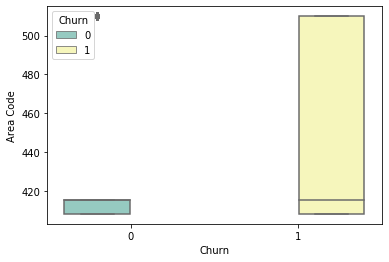

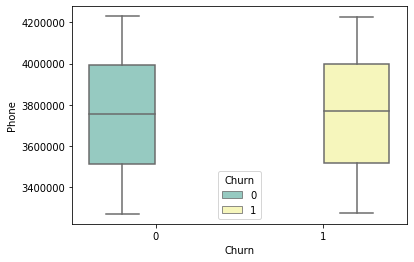

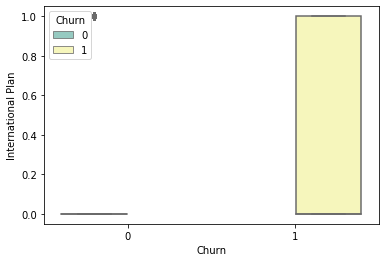

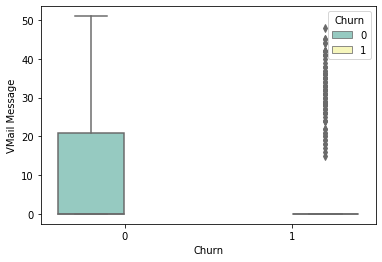

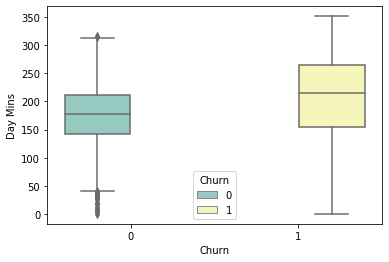

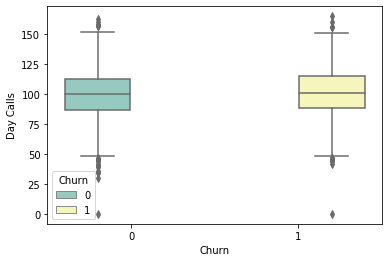

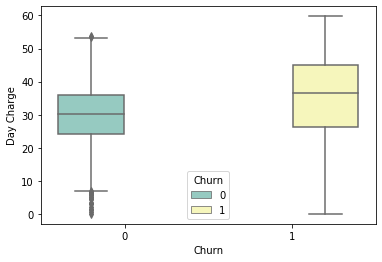

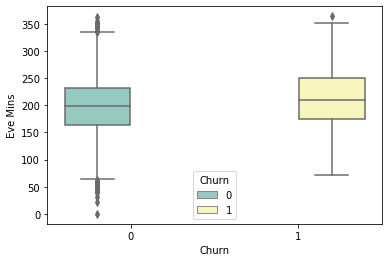

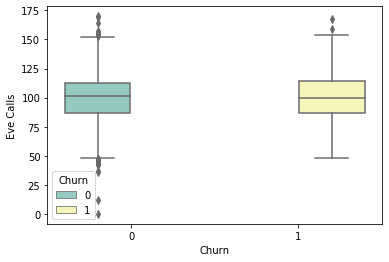

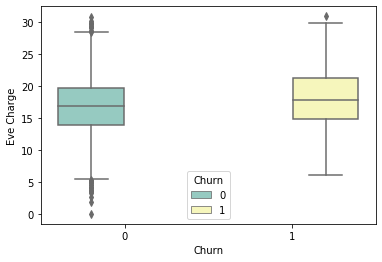

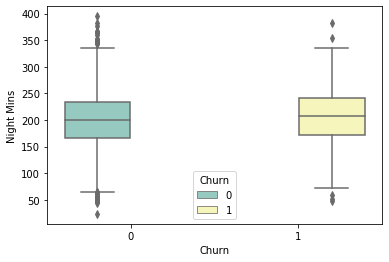

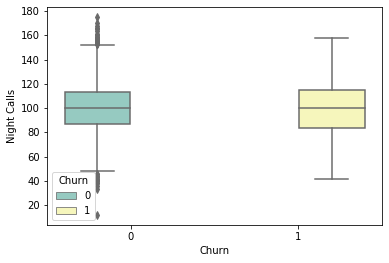

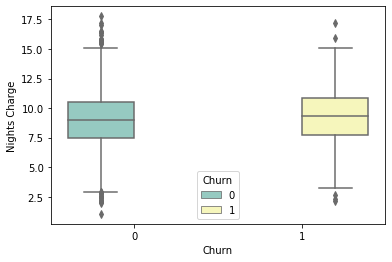

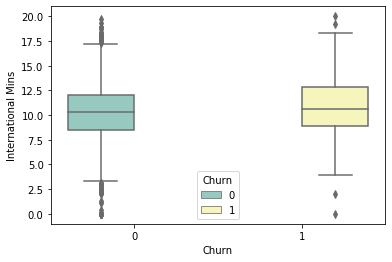

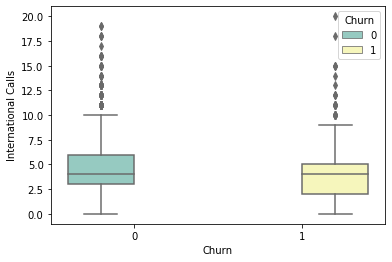

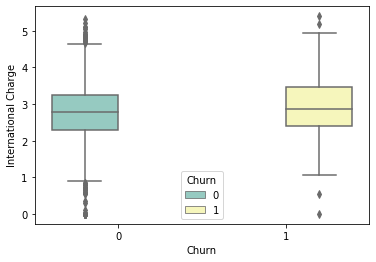

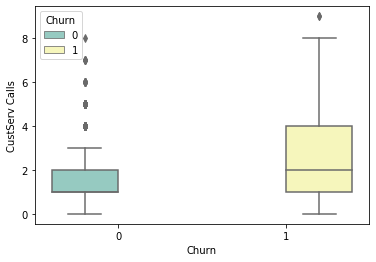

In [40]:
non_numerical = ['Internional Plan', 'VMail Plan', 'State', 'Churn']
churn = 'Churn'
for column in data_encoded.columns:
    if column not in non_numerical:
        ax = sns.boxplot(x=churn, y=column, data=data_encoded, hue=churn, palette="Set3")
        plt.show()
        # sns.boxplot(x=column, data=data_encoded[data_encoded[churn] == 1])
        # plt.show()
        # sns.boxplot(x=column, data=data_encoded[data_encoded[churn] == 0])
        # plt.show()

## Try various algorithms for the classification problems with grid search and gradually reducing the number of independent variables used

After appropriate grid searching select the best model

Try
Randomforest, Logistic regression, XGBoost, SVM, Neural network

with default setting only RandomForest and XGBoost was giving good results

In [41]:
models = [
    RandomForestClassifier(),
    svm.SVC(),
    LogisticRegression(),
    MLPClassifier(),
    XGBClassifier()
]
for model in models:

    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print(model, accuracy_score(y_test, y_predict))
    print(pd.crosstab(y_test, y_predict))
    print(classification_report(y_test, y_predict))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 0.9515151515151515
col_0    0    1
Churn          
0      992    4
1       52  107
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       996
           1       0.96      0.67      0.79       159

    accuracy                           0.95      1155
   macro avg       0.96      0.83      0.88      1155
weighted avg       0.95      0.95      0.95      1155

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3

### Adding Randomized search to it

In [42]:
cv = 5
random_state = [0, 42]  
models = [
    (RandomForestClassifier(), {'random_state': random_state,
                                'n_estimators': range(10, 30, 5),
                                'max_depth': range(10, 30, 5),
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4]
                               }
    ), 
    (svm.SVC(), {}),
    (LogisticRegression(), {'random_state': random_state}),
    (MLPClassifier(), {'random_state': random_state}),
    (XGBClassifier(), {'random_state': random_state})
]

for model, parameters in models:
    
    clf = RandomizedSearchCV(model, parameters, cv=cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    print(clf, accuracy_score(y_test, y_predict))
    print(clf.best_estimator_)
    print(pd.crosstab(y_test, y_predict))
    print(classification_report(y_test, y_predict))

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

### Try with less number of independent variables

In [43]:
best_features_list = [i[0] for i in best_features[:10]]

cv = 5
random_state = [0, 42]  
models = [
    (RandomForestClassifier(), {}),
    (RandomForestClassifier(), {'random_state': random_state,
                                'n_estimators': range(10, 30, 5),
                                'max_depth': range(10, 30, 5),
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4]
                               }
    ), 
    (svm.SVC(), {}),
    (LogisticRegression(), {'random_state': random_state}),
    (MLPClassifier(), {'random_state': random_state}),
    (XGBClassifier(), {'random_state': random_state})
]

X_train_best = X_train.loc[:,best_features_list]
X_test_best = X_test.loc[:, best_features_list]

for model, parameters in models:
    
    clf = RandomizedSearchCV(model, parameters, cv=cv)
    clf.fit(X_train_best, y_train)
    y_predict = clf.predict(X_test_best)
    print(clf, accuracy_score(y_test, y_predict))
    print(clf.best_estimator_)
    print(pd.crosstab(y_test, y_predict))
    print(classification_report(y_test, y_predict))

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
          

### Try after oversampling with smote



In [58]:

# sm = SMOTE(random_state=42)
# X = data_encoded.iloc[:, :-1]
# y = data_encoded.Churn
# print(Counter(y))
# X_smote, y_smote = sm.fit_resample(X, y)
# print(Counter(y_smote))


model = RandomForestClassifier()

test_size = .25
X = data_encoded.iloc[:, :-1]
y = data_encoded.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)


sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print(Counter(y_smote))

X_train = X_smote
y_train = y_smote


model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print(accuracy_score(y_test, y_predict))
print(pd.crosstab(y_test, y_predict))
print(classification_report(y_test, y_predict))
best_features = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1], reverse=True)

with open('feature_importances.txt', 'w') as f:
    best_features_1 = [(a, b.round(2)) for a, b in best_features]
    f.write(str(best_features_1))
best_features_1     


Counter({1: 2965, 0: 2965})
0.9264069264069265
col_0    0    1
Churn          
0      954   42
1       43  116
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       996
           1       0.73      0.73      0.73       159

    accuracy                           0.93      1155
   macro avg       0.85      0.84      0.84      1155
weighted avg       0.93      0.93      0.93      1155



[('International Plan', 0.19),
 ('CustServ Calls', 0.14),
 ('VMail Plan', 0.11),
 ('Day Charge', 0.09),
 ('Day Mins', 0.07),
 ('Area Code', 0.04),
 ('Eve Charge', 0.04),
 ('VMail Message', 0.03),
 ('Eve Mins', 0.03),
 ('International Calls', 0.03),
 ('State', 0.03),
 ('Phone', 0.02),
 ('Nights Charge', 0.02),
 ('Night Mins', 0.02),
 ('International Charge', 0.02),
 ('International Mins', 0.02),
 ('Day Calls', 0.02),
 ('Account Length', 0.02),
 ('Night Calls', 0.02),
 ('Eve Calls', 0.02)]

### Retry after oversampling

In [60]:
cv = 5
random_state = [0, 42]  
models = [
    (RandomForestClassifier(), {'random_state': random_state,
                                'n_estimators': range(10, 30, 5),
                                'max_depth': range(10, 30, 5),
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4]
                               }
    ), 
    (svm.SVC(), {}),
    (LogisticRegression(), {'random_state': random_state}),
#     (MLPClassifier(), {'random_state': random_state}),
    (XGBClassifier(), {'random_state': random_state})
]

for model, parameters in models:
    
    clf = RandomizedSearchCV(model, parameters, cv=cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test.values)
    print(clf, accuracy_score(y_test, y_predict))
    print(clf.best_estimator_)
    print(pd.crosstab(y_test, y_predict))
    print(classification_report(y_test, y_predict))

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [46]:
data_columns_to_indices_mapping = {j: i for i, j in enumerate(X.columns)}
data_columns_to_indices_series = pd.Series(data_columns_to_indices_mapping)

### Try with less only top 10 features

In [47]:
best_features_list
data_columns_to_indices_series[best_features_list]

Day Mins                7
Day Charge              9
CustServ Calls         19
International Plan      4
Eve Mins               10
Eve Charge             12
International Calls    17
Night Mins             13
International Mins     16
Nights Charge          15
dtype: int64

In [64]:
test_size = .25
X = data_encoded.iloc[:, :-1]
y = data_encoded.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)


sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print(Counter(y_smote))

X_train = X_smote
y_train = y_smote

cv = 5
random_state = [0, 42]  
models = [
    (RandomForestClassifier(), {'random_state': random_state,
                                'n_estimators': range(10, 30, 5),
                                'max_depth': range(10, 30, 5),
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4]
                               }
    ), 
    (svm.SVC(), {}),
    (LogisticRegression(), {'random_state': random_state}),
#     (MLPClassifier(), {'random_state': random_state}),
    (XGBClassifier(), {'random_state': random_state})
]

X_train = X_train[:, data_columns_to_indices_series[best_features_list]]
X_test = X_test.iloc[:, data_columns_to_indices_series[best_features_list]]
for model, parameters in models:
    
    clf = RandomizedSearchCV(model, parameters, cv=cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test.values)
    print(clf, accuracy_score(y_test, y_predict))
    print(clf.best_estimator_)
    print(pd.crosstab(y_test, y_predict))
    print(classification_report(y_test, y_predict))

Counter({1: 2965, 0: 2965})
RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                   

https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/

Best model I got was using XGBoost with all the features

## Try with less features based on chi square tests and after removing multicollinearity

### Best categorical features based on chi square tests
* State Churn 0.0003716382614441669
* International Plan Churn 5.1469217589105615e-68
* VMail Plan Churn 1.0310215433169948e-13

### Highest mulicollinearity features are
* {('Day Mins', 'Day Charge'): 1.0,
* ('Eve Mins', 'Eve Charge'): 1.0,
* ('Night Mins', 'Nights Charge'): 1.0,
* ('International Mins', 'International Charge'): 1.0}



In [49]:
{('Day Mins', 'Day Charge'): 1.0,
 ('Eve Mins', 'Eve Charge'): 1.0,
 ('Night Mins', 'Nights Charge'): 1.0,
 ('International Mins', 'International Charge'): 1.0}

{('Day Mins', 'Day Charge'): 1.0,
 ('Eve Mins', 'Eve Charge'): 1.0,
 ('Night Mins', 'Nights Charge'): 1.0,
 ('International Mins', 'International Charge'): 1.0}

In [50]:
best_features_list

['Day Mins',
 'Day Charge',
 'CustServ Calls',
 'International Plan',
 'Eve Mins',
 'Eve Charge',
 'International Calls',
 'Night Mins',
 'International Mins',
 'Nights Charge']

## Remove the best multicollinear features from the best features found using random forest
## Add the best categorical features found using chi square to the best features and form the new features list

In [51]:
for i in ['Day Mins', 'Eve Mins', 'Night Mins', 'International Mins']:
    try:
        best_features_list.remove(i)
    except:
        pass

features_categorical = [
    'State',
    'International Plan',
    'VMail Plan'
]

new_features_list = best_features_list + features_categorical
new_features_list
data_columns_to_indices_series[new_features_list]
new_features_list

['Day Charge',
 'CustServ Calls',
 'International Plan',
 'Eve Charge',
 'International Calls',
 'Nights Charge',
 'State',
 'International Plan',
 'VMail Plan']

In [ ]:

test_size = .25
X = data_encoded.iloc[:, :-1]
y = data_encoded.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)


sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print(Counter(y_smote))

X_train = X_smote
y_train = y_smote

cv = 5
random_state = [0, 42]  
models = [
    (RandomForestClassifier(), {'random_state': random_state,
                                'n_estimators': range(10, 30, 5),
                                'max_depth': range(10, 30, 5),
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4]
                               }
    ), 
    (svm.SVC(), {}),
    (LogisticRegression(), {'random_state': random_state}),
#     (MLPClassifier(), {'random_state': random_state}),
    (XGBClassifier(), {'random_state': random_state})
]

X_train = X_train[:, data_columns_to_indices_series[new_features_list]]
X_test = X_test.iloc[:, data_columns_to_indices_series[new_features_list]]
for model, parameters in models:
    
    clf = RandomizedSearchCV(model, parameters, cv=cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    print(clf, accuracy_score(y_test, y_predict))
    print(clf.best_estimator_)
    print(pd.crosstab(y_test, y_predict))
    print(classification_report(y_test, y_predict))

# XGBoost gave the best performance with 9 features
col_0    0    1
row_0          
0      956   40
1       59  926
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       996
           1       0.96      0.94      0.95       985

    accuracy                           0.95      1981
   macro avg       0.95      0.95      0.95      1981
weighted avg       0.95      0.95      0.95      1981

# Random forest also gave similar results
col_0    0    1
row_0          
0      959   37
1       63  922
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       996
           1       0.96      0.94      0.95       985

    accuracy                           0.95      1981
   macro avg       0.95      0.95      0.95      1981
weighted avg       0.95      0.95      0.95      1981

In [72]:
X = data_encoded.iloc[:,:-1]
y = data_encoded.Churn



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)

sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print(Counter(y_smote))

X_train = X_smote
y_train = y_smote

cv = 5
random_state = [42]  
models = [
    (RandomForestClassifier(), {'random_state': random_state,
                                'n_estimators': range(10, 30, 5),
                                'max_depth': range(10, 30, 5),
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4]
                               }
    ), 
    (svm.SVC(), {}),
    (LogisticRegression(), {'random_state': random_state}),
    #(MLPClassifier(), {'random_state': random_state}),
    (XGBClassifier(), {'random_state': random_state, "learning_rate"    : [0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }
)
]
  
X_train = X_train[:, data_columns_to_indices_series[new_features_list]]
X_test = X_test.iloc[:, data_columns_to_indices_series[new_features_list]]

clfs = []
for model, parameters in models:
    
    clf = RandomizedSearchCV(model, parameters, cv=cv)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    y_predict = clf.predict(X_test.values)
    print(clf, accuracy_score(y_test, y_predict))
    print(clf.best_estimator_)
    print(pd.crosstab(y_test, y_predict))
    print(classification_report(y_test, y_predict))
    


Counter({1: 2965, 0: 2965})
RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                   

In [96]:
from sklearn.ensemble import VotingClassifier

clfs_ = [(str(clf.best_estimator_).split('(')[0], clf.best_estimator_) for clf in clfs]
clfs_

vclf = VotingClassifier(estimators=clfs_, weights=[2, 1, 1, 2])
vclf.fit(X_train, y_train)
y_predict = vclf.predict(X_test.values)
print(vclf, accuracy_score(y_test, y_predict))

print(pd.crosstab(y_test, y_predict))
print(classification_report(y_test, y_predict))

[('RandomForestClassifier',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=20, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=20,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, probability=False, random_state=None,
      shrinking=True, tol=0.001, verbose=False)),
 ('LogisticRegression',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='war

In [102]:
from sklearn.ensemble import VotingClassifier

clfs_ = [(str(clf.best_estimator_).split('(')[0], clf.best_estimator_) for clf in [clfs[0], clfs[2], clfs[3]]]
clfs_

vclf = VotingClassifier(estimators=clfs_)
vclf.fit(X_train, y_train)
y_predict = vclf.predict(X_test.values)
print(vclf, accuracy_score(y_test, y_predict))

print(pd.crosstab(y_test, y_predict))
print(classification_report(y_test, y_predict))

VotingClassifier(estimators=[('RandomForestClassifier',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=20,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=20,
                                                     n_jobs